# Description:
This script contains an investigation of the average values for each window
on a per channel basis for an entire station. This investigation was done
twice, once while keeping the window unrolling as described in Figure 16 in
account (so as to investigate the physical windows) and once without keeping
this into account (in order to investigate the chronological windows)

# Import modules:

In [1]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot

In [2]:
%%capture out
%run ./Functions.ipynb

# Import data:
Import the data and investigate its structure

In [3]:
PedFileSt11R101=uproot.open("/mnt/c/Users/Jethro/Desktop/Master thesis/pedestal.root")
PedFileSt11R101[''].show(  name_width=22, typename_width=24, interpretation_width=30)

name                   | typename                 | interpretation                
-----------------------+--------------------------+-------------------------------
                       | mattak::Pedestals        | AsGroup(<TBranchElement '' ...
/TObject               | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
/TObject/fUniqueID     | uint32_t                 | AsDtype('>u4')
/TObject/fBits         | uint8_t                  | AsDtype('uint8')
/when                  | uint32_t                 | AsDtype('>u4')
/nevents               | uint32_t                 | AsDtype('>u4')
/mask                  | uint32_t                 | AsDtype('>u4')
/flags                 | uint8_t                  | AsDtype('uint8')
/station_number        | uint8_t                  | AsDtype('uint8')
/vbias[2]              | float[2]                 | AsDtype("('>f4', (2,))")
/pedestals[24][4096]   | uint16_t[24][4096]       | AsDtype("('>u2', (24, 4096))")


In [4]:
PedestalDataSt11R101=PedFileSt11R101['']['pedestals[24][4096]'].array(library='np')
print("The shape is: " + str(PedestalDataSt11R101.shape)) # 24 channels & 4096 samples
print(PedestalDataSt11R101[0])
#np.where(EventNumber==18)[0][0]

The shape is: (1, 24, 4096)
[[2524 2532 2519 ... 2548 2534 2543]
 [2533 2517 2520 ... 2548 2533 2531]
 [2485 2491 2488 ... 2524 2495 2497]
 ...
 [2474 2501 2502 ... 2514 2530 2490]
 [2500 2526 2501 ... 2529 2520 2511]
 [2521 2526 2497 ... 2543 2529 2506]]


In [5]:
WhenPedestalDataSt11R101=PedFileSt11R101['']['when'].array(library='np')
print("The shape is: " + str(WhenPedestalDataSt11R101.shape)) # 24 channels & 4096 samples
print(WhenPedestalDataSt11R101)

The shape is: (1,)
[1627713501]


In [6]:
RadFileSt11R101=uproot.open("/mnt/c/Users/Jethro/Desktop/Master thesis/RNO_DATA_DIR/station11/run101/combined.root") #When from ubuntu
RadiantDataSt11R101=RadFileSt11R101['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrsSt11R101=RadFileSt11R101['combined']['waveforms']['event_number'].array(library="np")
StartWindowSt11R101 = np.array(RadFileSt11R101['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
print("Shape of the radiant_data[24][2048] AsDtype is:")
print(RadiantDataSt11R101.shape) #107 is for events, 24 channels and 2048 for samples

print("The event numbers are:")
print(EventNrsSt11R101)

Shape of the radiant_data[24][2048] AsDtype is:
(107, 24, 2048)
The event numbers are:
[  6  16  18  19  23  32  33  34  37  40  54  61  67  68  76  79  82  84
  88 101 102 107 109 112 114 118 119 128 135 147 155 156 164 167 170 172
 189 193 197 199 217 218 220 252 254 261 268 269 277 279 282 283 291 294
 307 318 320 343 347 360 363 366 372 378 388 389 393 397 398 403 417 436
 438 440 449 456 463 466 467 474 481 501 502 508 521 526 529 557 576 581
 607 608 609 612 614 618 632 644 666 667 675 681 683 686 691 712 716]


In [7]:
print("Shape of the start_windows[24][2]  is:")
print(StartWindowSt11R101.shape) #107 is for events, 24 channels and 2048 for samples
print("And it looks like:")
print(StartWindowSt11R101)
print("For first 24 events:")
for i in range(24):
    print(StartWindowSt11R101[i][0]) #107 is for events, 24 channels and 2 for start

Shape of the start_windows[24][2]  is:
(107, 24, 2)
And it looks like:
[[[ 0  8]
  [ 0  8]
  [ 0  8]
  ...
  [ 0  8]
  [ 0  8]
  [ 0  8]]

 [[ 3 11]
  [ 3 11]
  [ 3 11]
  ...
  [ 3 11]
  [ 3 11]
  [ 3 11]]

 [[ 4 12]
  [ 4 12]
  [ 4 12]
  ...
  [ 4 12]
  [ 4 12]
  [ 4 12]]

 ...

 [[21 29]
  [21 29]
  [21 29]
  ...
  [21 29]
  [21 29]
  [21 29]]

 [[ 2 10]
  [ 2 10]
  [ 2 10]
  ...
  [ 2 10]
  [ 2 10]
  [ 2 10]]

 [[ 7 15]
  [ 7 15]
  [ 7 15]
  ...
  [ 7 15]
  [ 7 15]
  [ 7 15]]]
For first 24 events:
[0 8]
[ 3 11]
[ 4 12]
[19 27]
[21 29]
[ 6 14]
[22 30]
[ 2 10]
[16 24]
[ 4 12]
[ 5 13]
[20 28]
[22 30]
[1 9]
[ 2 10]
[19 27]
[0 8]
[0 8]
[1 9]
[19 27]
[ 7 15]
[16 24]
[20 28]
[ 6 14]


# Window averages:
Compute the average adc count per (chronological or physical) window

## Rolled

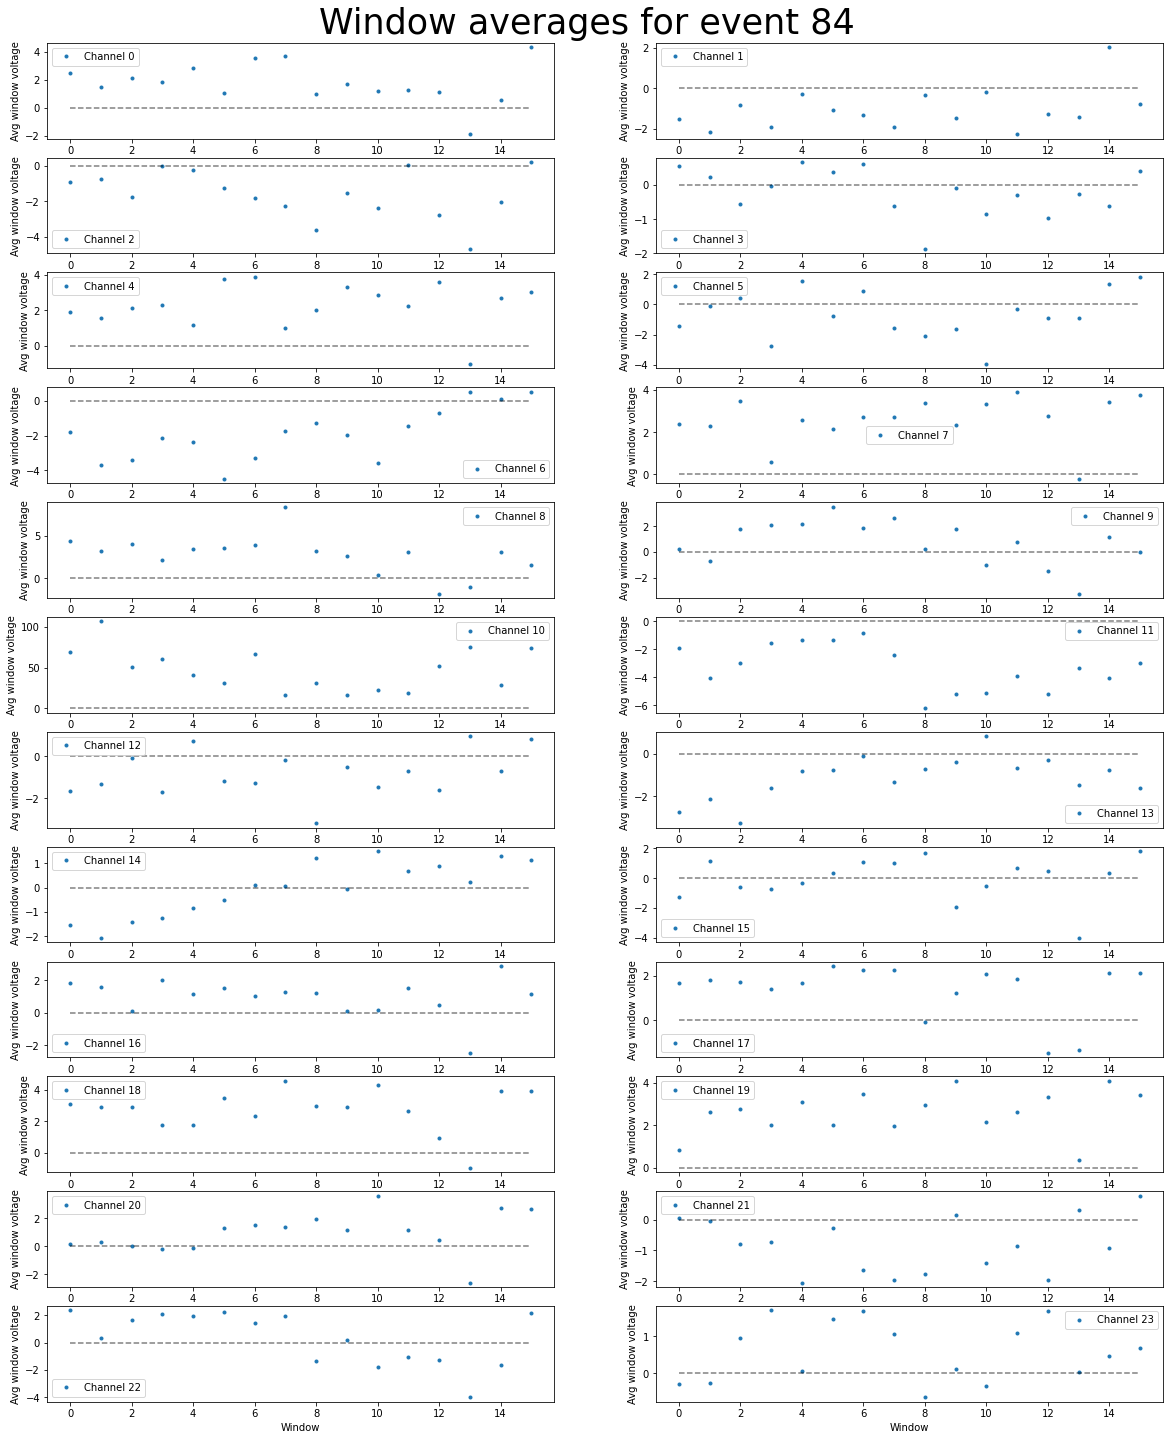

In [8]:
WindowAvgPlot(84,RadiantDataSt11R101,EventNrsSt11R101)

## Unrolled

The unrolling process for old firmware for e.g. [3,11] -> [3,7] + [0,2] + [11,15] + [8,10]

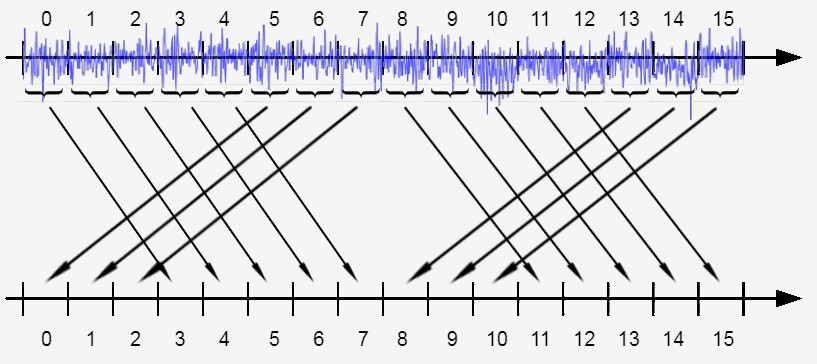

Example of unrolling with starting windows [3,11]; this should yield [3,7] + [0,2] + [11,15] + [8,10]

In [9]:
OldUnroll(3,11)

[3, 4, 5, 6, 7, 0, 1, 2, 11, 12, 13, 14, 15, 8, 9, 10]

In [10]:
OldUnroll(20,28)

[20, 21, 22, 23, 16, 17, 18, 19, 28, 29, 30, 31, 24, 25, 26, 27]

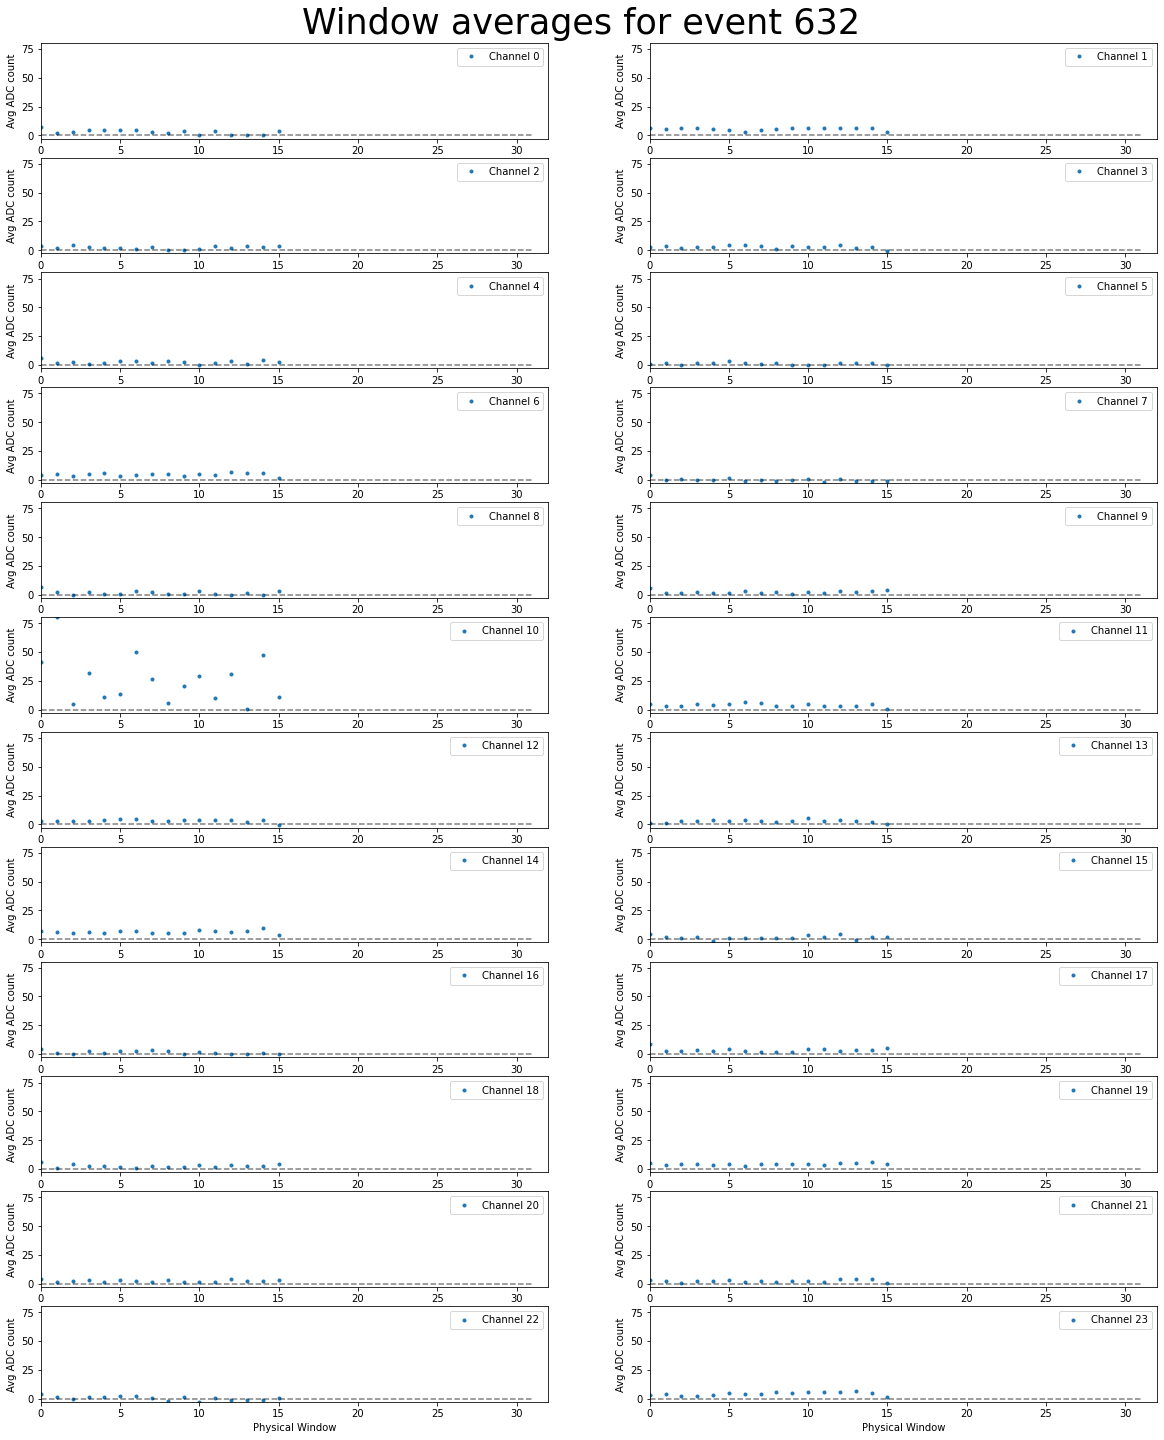

In [11]:
PhysicalWindowAvgPlot(632,RadiantDataSt11R101,EventNrsSt11R101,StartWindowSt11R101,11,101)

# With Pedestal:
Now doing the same but for the pre-pedestal subtracted waveform data.

In [12]:
PedFileSt11R101=uproot.open("/mnt/c/Users/Jethro/Desktop/Master thesis/pedestal.root")
PedFileSt11R101[''].show(  name_width=22, typename_width=24, interpretation_width=30)

name                   | typename                 | interpretation                
-----------------------+--------------------------+-------------------------------
                       | mattak::Pedestals        | AsGroup(<TBranchElement '' ...
/TObject               | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
/TObject/fUniqueID     | uint32_t                 | AsDtype('>u4')
/TObject/fBits         | uint8_t                  | AsDtype('uint8')
/when                  | uint32_t                 | AsDtype('>u4')
/nevents               | uint32_t                 | AsDtype('>u4')
/mask                  | uint32_t                 | AsDtype('>u4')
/flags                 | uint8_t                  | AsDtype('uint8')
/station_number        | uint8_t                  | AsDtype('uint8')
/vbias[2]              | float[2]                 | AsDtype("('>f4', (2,))")
/pedestals[24][4096]   | uint16_t[24][4096]       | AsDtype("('>u2', (24, 4096))")


In [13]:
PedestalDataSt11R101=PedFileSt11R101['']['pedestals[24][4096]'].array(library='np')
print("The shape is: " + str(PedestalDataSt11R101.shape)) # 24 channels & 4096 samples
print(PedestalDataSt11R101[0])
#np.where(EventNumber==18)[0][0]

The shape is: (1, 24, 4096)
[[2524 2532 2519 ... 2548 2534 2543]
 [2533 2517 2520 ... 2548 2533 2531]
 [2485 2491 2488 ... 2524 2495 2497]
 ...
 [2474 2501 2502 ... 2514 2530 2490]
 [2500 2526 2501 ... 2529 2520 2511]
 [2521 2526 2497 ... 2543 2529 2506]]


Plotting the pedestal values

No handles with labels found to put in legend.


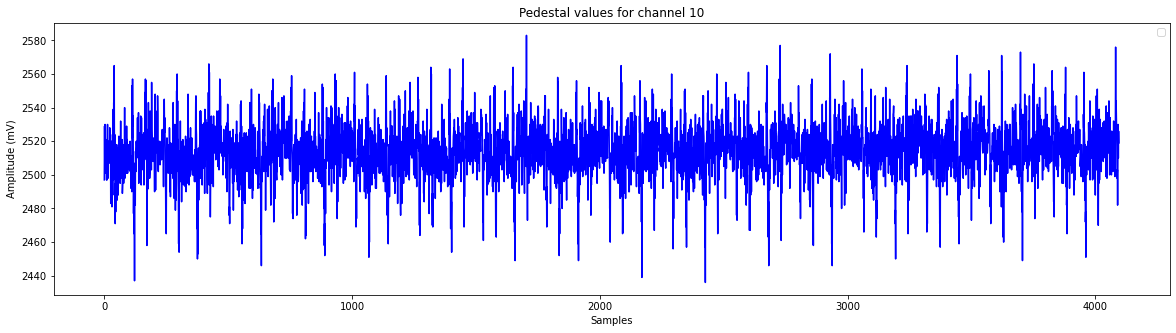

In [14]:
PedestalPlot(10,PedestalDataSt11R101)

In [15]:
RadFileSt11R101=uproot.open("/mnt/c/Users/Jethro/Desktop/Master thesis/RNO_DATA_DIR/station11/run101/combined.root") #When from ubuntu
RadiantDataSt11R101=RadFileSt11R101['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrsSt11R101=RadFileSt11R101['combined']['waveforms']['event_number'].array(library="np")
StartWindowSt11R101 = np.array(RadFileSt11R101['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])
print("Shape of the radiant_data[24][2048] AsDtype is:")
print(RadiantDataSt11R101.shape) #107 is for events, 24 channels and 2048 for samples

print("The event numbers are:")
print(EventNrsSt11R101)

Shape of the radiant_data[24][2048] AsDtype is:
(107, 24, 2048)
The event numbers are:
[  6  16  18  19  23  32  33  34  37  40  54  61  67  68  76  79  82  84
  88 101 102 107 109 112 114 118 119 128 135 147 155 156 164 167 170 172
 189 193 197 199 217 218 220 252 254 261 268 269 277 279 282 283 291 294
 307 318 320 343 347 360 363 366 372 378 388 389 393 397 398 403 417 436
 438 440 449 456 463 466 467 474 481 501 502 508 521 526 529 557 576 581
 607 608 609 612 614 618 632 644 666 667 675 681 683 686 691 712 716]


## Pedestal re-addition

**How to re-add pedestal:**
Take a certain window in the waveform, compute it's corresponding physical window. Look at this physical window in the Pedestal data (Pedestal data is in order of physical windows). Add this Pedestal window sample-wise to the original waveform window. 

## Compute data with pedestal values

In [16]:
RadiantDataWPedSt11R101=WaveformWithPedestals(RadiantDataSt11R101,StartWindowSt11R101,PedestalDataSt11R101,EventNrsSt11R101,11,101)

For "blocky" event:

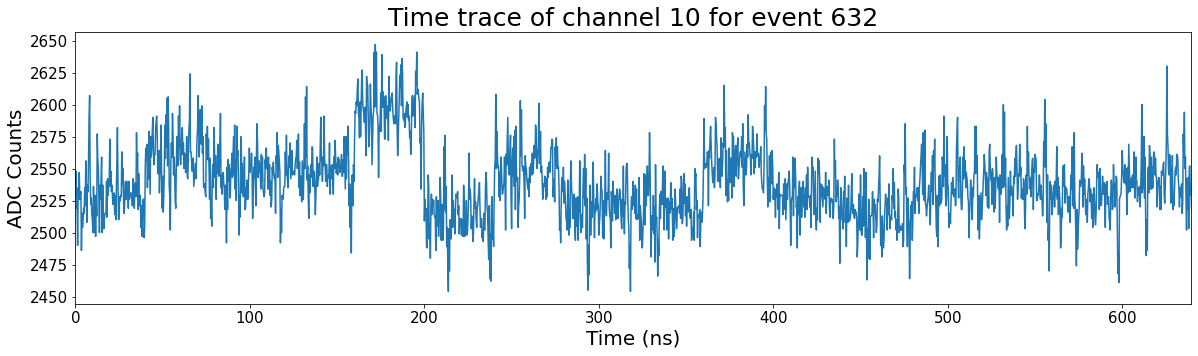

In [17]:
TimeTrace(10,632,RadiantDataWPedSt11R101,EventNrsSt11R101)

For some other event:

## Unrolled window averages with pedestal

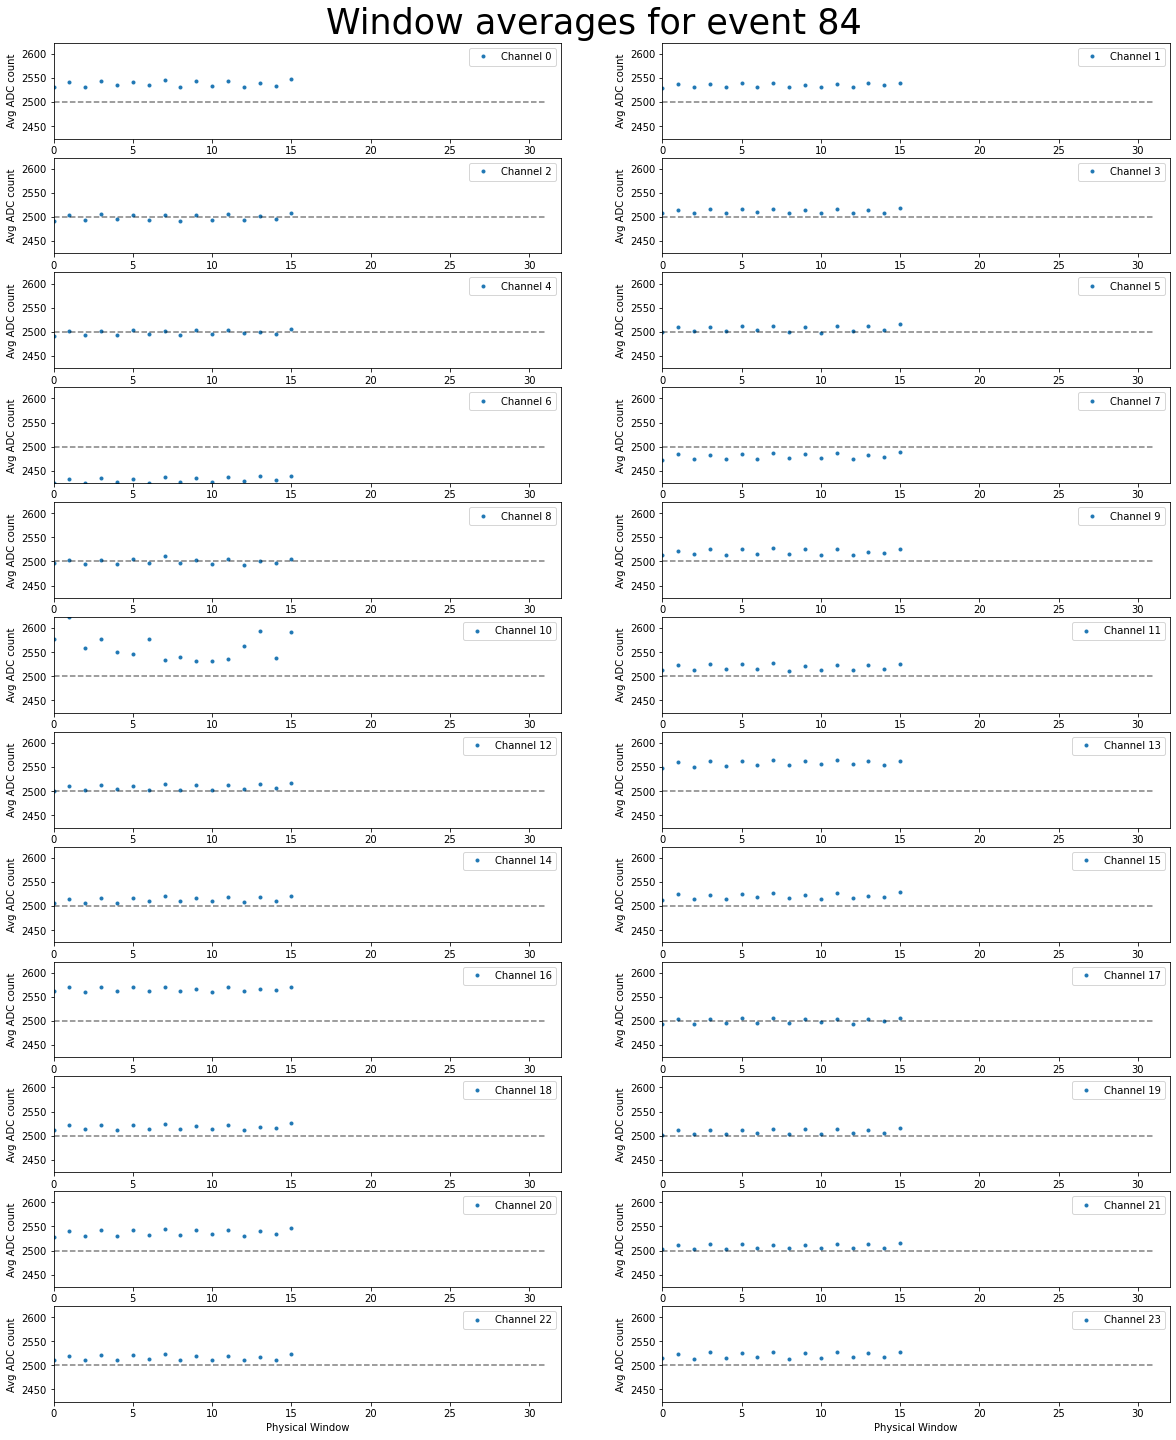

In [18]:
PhysicalWindowAvgPlot(EventNrsSt11R101[17],RadiantDataWPedSt11R101,EventNrsSt11R101,StartWindowSt11R101,11,101,Zeropoint=2500)
#print("Start windows for channel 10 are " + str([start_window[17][10][0],start_window[17][10][1]]))